In [1]:
from tensorflow.keras.models import load_model

# Load previously trained mango model
model = load_model("mango_leaf_disease_mobilenetv2.h5")

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [3]:
data_dir = r"C:\Users\Jaero\Desktop\Programming\DP1\Plant_Disease_Prediction\data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)


Found 2100 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 299 files belonging to 3 classes.


In [12]:
class_names = ['Anthracnose', 'Healthy', 'OtherDisease']

In [4]:
def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

In [5]:
for layer in model.layers[:-20]:
    layer.trainable = False

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # small LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "fine_tuned_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
66/66 [==============================] - 16s 95ms/step - loss: 1.0368 - accuracy: 0.6190 - val_loss: 0.8998 - val_accuracy: 0.6567
Epoch 2/50
66/66 [==============================] - 6s 79ms/step - loss: 0.9489 - accuracy: 0.6571 - val_loss: 0.7992 - val_accuracy: 0.6783
Epoch 3/50
66/66 [==============================] - 5s 76ms/step - loss: 0.8493 - accuracy: 0.6819 - val_loss: 0.7330 - val_accuracy: 0.7000
Epoch 4/50
66/66 [==============================] - 5s 74ms/step - loss: 0.7718 - accuracy: 0.6910 - val_loss: 0.6909 - val_accuracy: 0.7050
Epoch 5/50
66/66 [==============================] - 5s 75ms/step - loss: 0.7692 - accuracy: 0.7024 - val_loss: 0.6589 - val_accuracy: 0.7100
Epoch 6/50
66/66 [==============================] - 6s 79ms/step - loss: 0.7257 - accuracy: 0.7105 - val_loss: 0.6333 - val_accuracy: 0.7150
Epoch 7/50
66/66 [==============================] - 5s 76ms/step - loss: 0.7009 - accuracy: 0.7181 - val_loss: 0.6118 - val_accuracy: 0.7233
Epoch 8/50
6

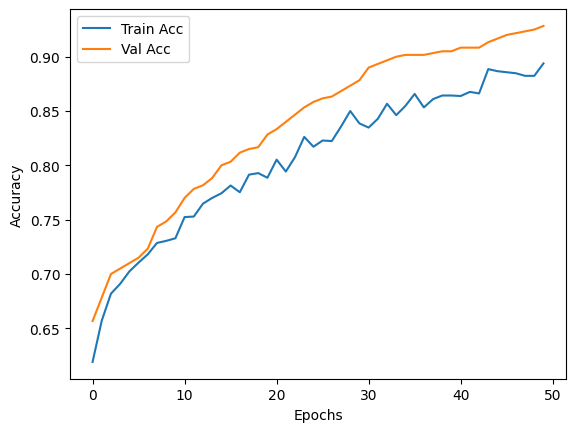

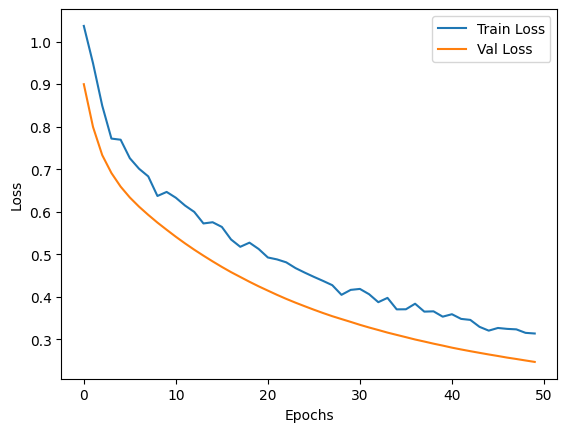

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

 Anthracnose       0.96      0.97      0.97       100
     Healthy       0.88      0.96      0.92       100
OtherDisease       0.93      0.84      0.88        99

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



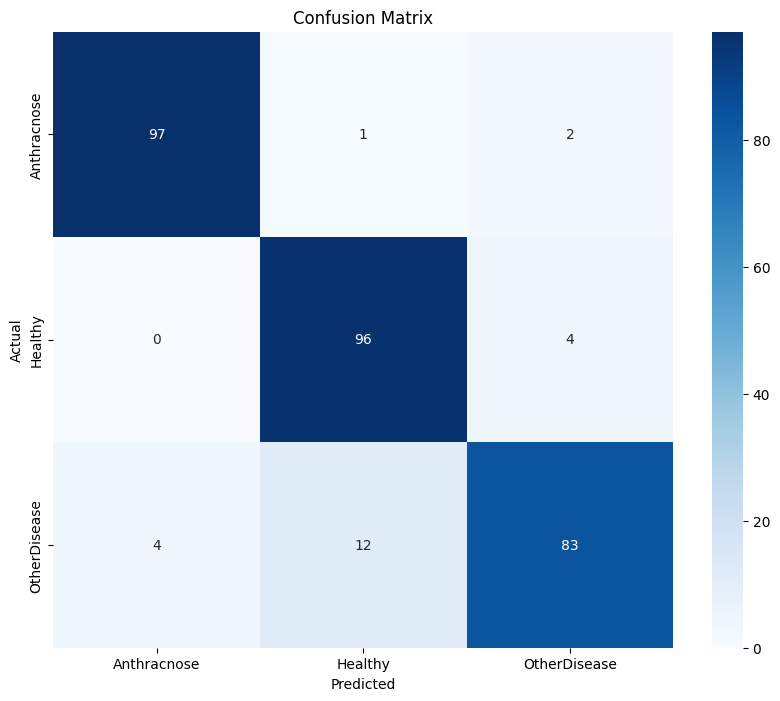

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true and y_pred_classes are already correct
# class_names is your list of class labels

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    print("Predicted:", preds)
    print("Actual   :", labels.numpy())

1/1 [==============================] - 0s 49ms/step
Predicted: [0 0 0 0 1 0 1 0 1 1 2 1 1 2 2 1 2 2 1 1 1 2 0 0 2 1 1 0 0 1 2 1]
Actual   : [0 0 0 0 1 0 1 2 1 2 2 1 1 2 2 1 1 2 1 1 1 2 0 0 2 1 1 0 0 2 2 1]


In [16]:
model.save('ft1_mango_leaf_disease.h5')